## 텐서플로우로 회귀 모델 만들기
* [자동차 연비 예측하기: 회귀  |  TensorFlow Core](https://www.tensorflow.org/tutorials/keras/regression?hl=ko)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
base_path = "data"
train = pd.read_csv(f'{base_path}/train.csv.zip', index_col="ID")
test = pd.read_csv(f'{base_path}/test.csv.zip', index_col="ID")
submission = pd.read_csv(f'{base_path}/sample_submission.csv.zip', index_col="ID")

In [3]:
categorical_feature = train.select_dtypes(include="object").columns
train[categorical_feature] = train[categorical_feature].astype("category")
test[categorical_feature] = test[categorical_feature].astype("category")

In [4]:
X, y = train.drop(columns="y"), train["y"]
X.shape, y.shape

((4209, 376), (4209,))

In [5]:
# train_test_split을 이용해 X, y 값을 X_train, X_valid, y_train, y_valid 으로 나눠줍니다.
# Hold-out-valiation을 위해 train, valid 세트로 나누기
# test_size=0.1 => 이름은 test지만 train으로 나눠주었기 때문에 valid 사이즈를 지정한 것입니다.
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.05, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((3998, 376), (211, 376), (3998,), (211,))

In [6]:
X_test = test

In [7]:
from sklearn.preprocessing import OrdinalEncoder

oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

X_train[categorical_feature] = oe.fit_transform(X_train[categorical_feature])
X_valid[categorical_feature] = oe.transform(X_valid[categorical_feature])
X_test[categorical_feature] = oe.transform(X_test[categorical_feature])

<img src="https://cs231n.github.io/assets/nn1/neural_net.jpeg" width="30%"> <img src="https://cs231n.github.io/assets/nn1/neural_net2.jpeg" width="40%">

* 이미지 출처 : https://cs231n.github.io/neural-networks-1/

## 딥러닝 레이어 만들기

In [29]:
import tensorflow as tf

model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=X_train.shape[1]),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.RMSprop(0.001)

model.compile(loss='mse',
            optimizer=optimizer,
            metrics=['mae', 'mse'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               48256     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 48,385
Trainable params: 48,385
Non-trainable params: 0
_________________________________________________________________


## 학습

In [10]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(X_train, y_train, epochs=1000,
                    validation_data=(X_valid, y_valid), verbose=0, callbacks=early_stop)

In [26]:
df_hist = pd.DataFrame(history.history)
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
20,114.002541,7.636215,114.002541,56.015652,5.761649,56.015652,20
21,116.802689,7.717707,116.802689,55.404232,5.170109,55.404232,21
22,116.159088,7.752244,116.159088,54.542904,5.292174,54.542904,22
23,115.236237,7.716792,115.236237,57.780243,6.005029,57.780243,23
24,116.821014,7.739144,116.821014,56.191444,5.375562,56.191444,24


<Axes: >

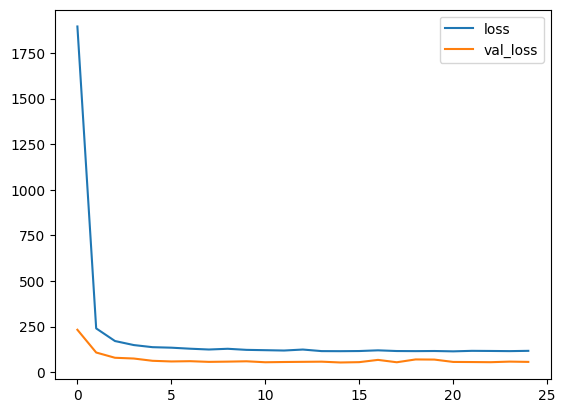

In [27]:
df_hist[["loss", "val_loss"]].plot()

<Axes: >

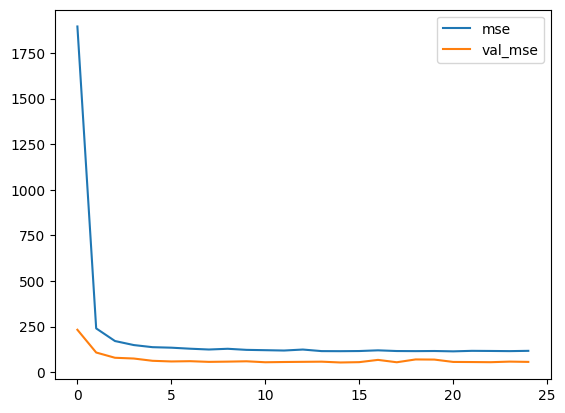

In [28]:
df_hist[["mse", "val_mse"]].plot()

## 평가

In [13]:
loss, mae, mse = model.evaluate(X_valid, y_valid, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f}".format(mae))

7/7 - 0s - loss: 56.1914 - mae: 5.3756 - mse: 56.1914 - 21ms/epoch - 3ms/step
테스트 세트의 평균 절대 오차:  5.38


In [14]:
y_valid_pred = model.predict(X_valid).flatten()
y_valid_pred[:5]

7/7 [==============================] - 0s 1ms/step


array([ 90.62963,  96.61305, 110.9728 ,  75.03518, 112.979  ],
      dtype=float32)

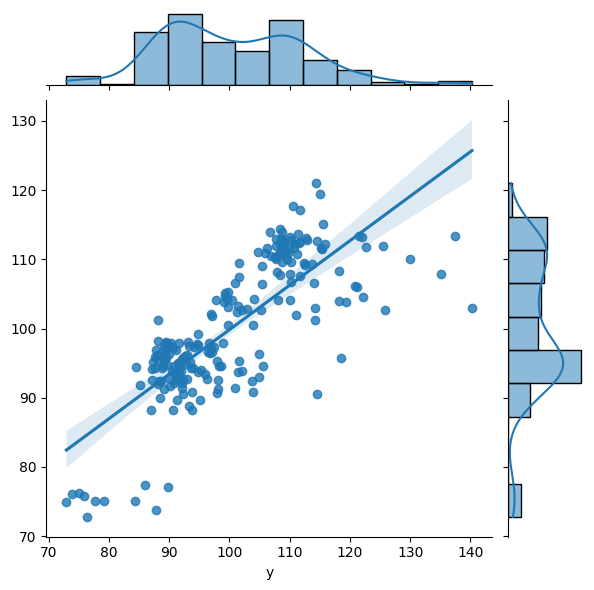

In [15]:
sns.jointplot(x=y_valid, y=y_valid_pred, kind="reg")

### R Square Score

In [16]:
from sklearn.metrics import r2_score

r2 = r2_score(y_valid, y_valid_pred)
r2

0.6033660986241094

### MAE

In [17]:
error = y_valid - y_valid_pred
mae = abs(error).mean()
mae

5.3755621120941015

### MAPE(Mean absolute percentage error)

In [18]:
mape = abs((y_valid - y_valid_pred) / y_valid).mean()
mape

0.05211372287975

### MSE

In [19]:
mse = (error) ** 2
mse = mse.mean()
mse

56.19143745033449

### RMSE

In [20]:
np.sqrt(mse)

7.496094813323434

## 예측

In [21]:
y_pred = model.predict(X_test)
y_pred[:5]

132/132 [==============================] - 0s 833us/step


array([[ 71.71349 ],
       [ 92.39322 ],
       [ 72.55736 ],
       [ 78.26403 ],
       [109.268166]], dtype=float32)

In [22]:
y_predict = y_pred.flatten()
y_predict

array([ 71.71349,  92.39322,  72.55736, ...,  91.86704, 109.51354,
        96.2481 ], dtype=float32)

https://www.kaggle.com/competitions/mercedes-benz-greener-manufacturing/submissions

In [23]:
submission["y"] = y_predict

In [24]:
file_name = f"submit_tf_{r2:.5f}.csv"
file_name

'submit_tf_0.60337.csv'

In [25]:
submission.to_csv(file_name)
pd.read_csv(file_name).head(2)

,ID,y
0,1,71.71349
1,2,92.39322
